In [6]:

# ===== 0) Imports and configuration =====
import os, json, math, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score,
                             average_precision_score, precision_recall_curve, roc_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

from joblib import dump, load

warnings.filterwarnings("ignore")

# Paths
DATA_PATH = "Fraud.csv"       # <-- change this to your CSV location if needed
ART_DIR = Path("artifacts"); ART_DIR.mkdir(exist_ok=True)

# Sampling (tune to your laptop; 200k is a good start)
SAMPLE_NROWS = 200_000
RANDOM_STATE = 42

print("Notebook ready. If you get memory errors, reduce SAMPLE_NROWS.")


Notebook ready. If you get memory errors, reduce SAMPLE_NROWS.


In [7]:

# ===== 1.1) Load a manageable sample for exploration/modeling =====
# If file is huge, reading all rows may be slow. Use nrows to keep memory reasonable.
df = pd.read_csv(DATA_PATH, nrows=SAMPLE_NROWS)

print("Sample shape:", df.shape)
print(df.head(3))
print("\nColumn dtypes:")
print(df.dtypes)

# Basic checks
print("\nMissing values per column:")
print(df.isnull().sum())

print("\nClass balance (isFraud):")
print(df['isFraud'].value_counts(dropna=False))


Sample shape: (200000, 11)
   step      type   amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT  9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT  1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER   181.00  C1305486145          181.0            0.00   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  

Column dtypes:
step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

Missing values per column:
step              0
type            

In [8]:

# ===== 1.2) Handle missing values & duplicates =====
# Dataset often has no NaNs in core columns, but let's be robust.
df = df.copy()
num_cols_possible = ["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"]
for c in num_cols_possible:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Impute numerics with 0 when missing (PaySim "unknowns" often come as 0 for merchants)
df[num_cols_possible] = df[num_cols_possible].fillna(0.0)

# Drop exact duplicate rows if any
before = len(df)
df = df.drop_duplicates()
after = len(df)
print(f"Duplicates removed: {before - after}")


Duplicates removed: 0


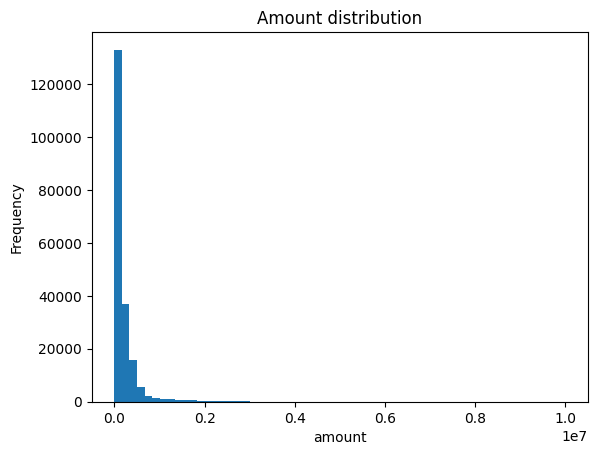

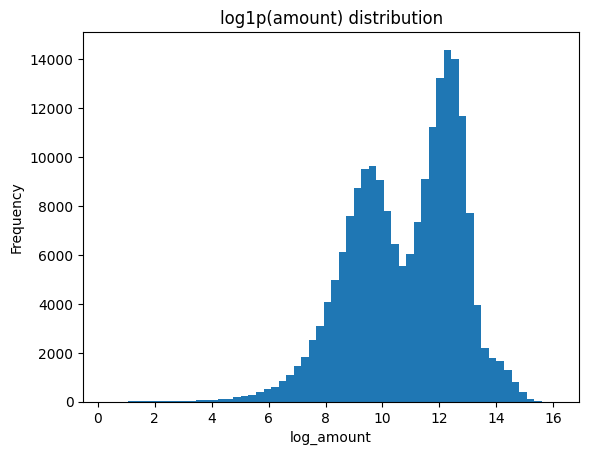

In [9]:

# ===== 1.3) Outliers: Amount distribution & log transform =====
# Fraud amounts can be very skewed. We'll inspect and create a log transform.
df['log_amount'] = np.log1p(df['amount'])

# Quick visualization: amount vs log_amount (separate plots, per instructions)
plt.figure()
df['amount'].plot(kind='hist', bins=60, title='Amount distribution')
plt.xlabel('amount')
plt.show()

plt.figure()
df['log_amount'].plot(kind='hist', bins=60, title='log1p(amount) distribution')
plt.xlabel('log_amount')
plt.show()


In [10]:

# ===== 1.4) Multi-collinearity (simple correlation + optional VIF) =====
# We'll create engineered diffs and check correlations among numeric features.
df['orig_diff'] = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']
df['dest_diff'] = df['newbalanceDest'] - df['oldbalanceDest'] - df['amount']

num_for_corr = ['amount','log_amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','orig_diff','dest_diff']
num_for_corr = [c for c in num_for_corr if c in df.columns]
corr = df[num_for_corr].corr()

print("Correlation matrix (numeric features):")
print(corr.round(3))

# Optional: VIF (Variance Inflation Factor) if statsmodels is available.
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    import statsmodels.api as sm

    X_vif = df[num_for_corr].fillna(0.0).astype(float)
    X_vif = sm.add_constant(X_vif)
    vif = []
    for i in range(1, X_vif.shape[1]):  # skip the intercept at 0
        vif.append((num_for_corr[i-1], variance_inflation_factor(X_vif.values, i)))
    vif_df = pd.DataFrame(vif, columns=['feature','VIF'])
    print("\nVIF (lower is better; >10 is problematic):")
    print(vif_df.sort_values('VIF', ascending=False).to_string(index=False))
except Exception as e:
    print("\nVIF skipped (statsmodels not installed or failed). That's fine for this assignment.")


Correlation matrix (numeric features):
                amount  log_amount  oldbalanceOrg  newbalanceOrig  \
amount           1.000       0.637         -0.020          -0.024   
log_amount       0.637       1.000          0.097           0.101   
oldbalanceOrg   -0.020       0.097          1.000           0.999   
newbalanceOrig  -0.024       0.101          0.999           1.000   
oldbalanceDest   0.221       0.285          0.097           0.099   
newbalanceDest   0.345       0.351          0.066           0.065   
orig_diff       -0.922      -0.653         -0.081          -0.094   
dest_diff        0.085       0.063         -0.066          -0.073   

                oldbalanceDest  newbalanceDest  orig_diff  dest_diff  
amount                   0.221           0.345     -0.922      0.085  
log_amount               0.285           0.351     -0.653      0.063  
oldbalanceOrg            0.097           0.066     -0.081     -0.066  
newbalanceOrig           0.099           0.065     -0.0

In [11]:

# ===== 3.1) Feature engineering function =====
def engineer_features(df_in: pd.DataFrame):
    df2 = df_in.copy()

    # Numeric coercion
    for c in ["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"]:
        if c in df2.columns:
            df2[c] = pd.to_numeric(df2[c], errors="coerce").fillna(0.0)

    # Derived features
    df2["log_amount"] = np.log1p(df2["amount"])
    df2["orig_diff"] = df2["oldbalanceOrg"] - df2["newbalanceOrig"] - df2["amount"]
    df2["dest_diff"] = df2["newbalanceDest"] - df2["oldbalanceDest"] - df2["amount"]
    df2["orig_zero_then_zero"] = ((df2["oldbalanceOrg"]==0) & (df2["newbalanceOrig"]==0) & (df2["amount"]>0)).astype(int)
    df2["dest_zero_then_nonzero"] = ((df2["oldbalanceDest"]==0) & (df2["newbalanceDest"]>0)).astype(int)

    # Merchant vs customer destination
    dest_ser = df2["nameDest"].astype(str).fillna("")
    df2["dest_is_merchant"] = dest_ser.str.startswith("M").astype(int)

    # Keep modeling columns
    keep = [
        "type",
        "amount","log_amount",
        "orig_diff","dest_diff",
        "orig_zero_then_zero","dest_zero_then_nonzero","dest_is_merchant",
        "step"  # may capture time-of-day/week patterns
    ]
    X = df2[keep].copy()
    y = df2["isFraud"].astype(int)
    return X, y

X, y = engineer_features(df)
print("X shape:", X.shape, " y positive rate:", y.mean().round(4))


X shape: (200000, 9)  y positive rate: 0.0007


In [12]:

# ===== 4.1) Split =====
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Preprocess: one-hot encode 'type', passthrough numerics
cat_cols = ["type"]
num_cols = [c for c in X.columns if c not in cat_cols]

pre = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)


In [13]:

# ===== 4.2) Class weights for imbalance =====
classes = np.array([0,1])
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
CLASS_WEIGHT = {0: cw[0], 1: cw[1]}
print("Computed class weights:", CLASS_WEIGHT)


Computed class weights: {0: 0.5003690221538385, 1: 677.9661016949152}


In [14]:

# ===== 4.3) Train models =====
lr = LogisticRegression(max_iter=2000, class_weight=CLASS_WEIGHT, solver="lbfgs")
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    class_weight=CLASS_WEIGHT
)

pipe_lr = Pipeline([("pre", pre), ("model", lr)])
pipe_rf = Pipeline([("pre", pre), ("model", rf)])

pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)

proba_lr = pipe_lr.predict_proba(X_valid)[:,1]
proba_rf = pipe_rf.predict_proba(X_valid)[:,1]

# Metrics
def summarize_metrics(y_true, proba, name):
    roc = roc_auc_score(y_true, proba)
    pr = average_precision_score(y_true, proba)
    print(f"{name} -> ROC-AUC: {roc:.4f} | PR-AUC: {pr:.4f}")
    return roc, pr

roc_lr, pr_lr = summarize_metrics(y_valid, proba_lr, "LogReg")
roc_rf, pr_rf = summarize_metrics(y_valid, proba_rf, "RandForest")


LogReg -> ROC-AUC: 0.9926 | PR-AUC: 0.1606
RandForest -> ROC-AUC: 0.9992 | PR-AUC: 0.6866


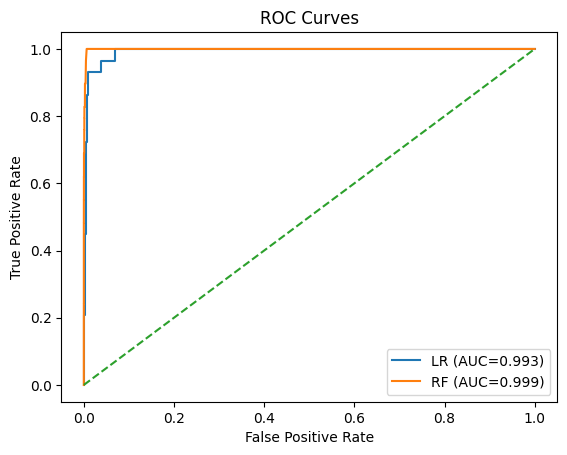

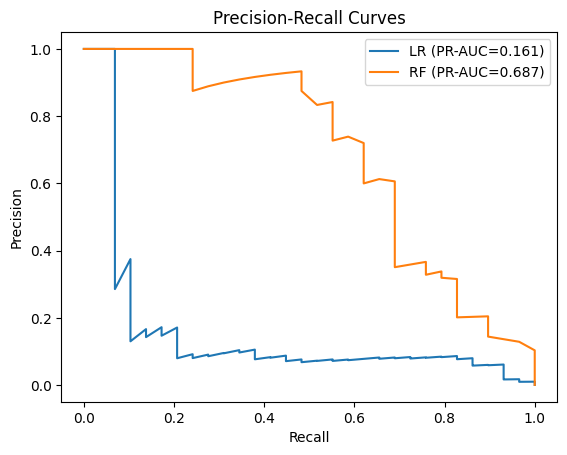

In [15]:

# ===== 4.4) Plot ROC and PR curves (single-figure for each chart) =====
# ROC
fpr_lr, tpr_lr, _ = roc_curve(y_valid, proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_valid, proba_rf)

plt.figure()
plt.plot(fpr_lr, tpr_lr, label=f"LR (AUC={roc_lr:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC={roc_rf:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# PR
prec_lr, rec_lr, _ = precision_recall_curve(y_valid, proba_lr)
prec_rf, rec_rf, _ = precision_recall_curve(y_valid, proba_rf)

plt.figure()
plt.plot(rec_lr, prec_lr, label=f"LR (PR-AUC={pr_lr:.3f})")
plt.plot(rec_rf, prec_rf, label=f"RF (PR-AUC={pr_rf:.3f})")
plt.title("Precision-Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()


In [16]:

# ===== 4.5) Threshold tuning (maximize recall subject to workable precision) =====
def choose_threshold_by_recall(y_true, proba, target_recall=0.80):
    prec, rec, thr = precision_recall_curve(y_true, proba)
    # If target recall achievable, pick min threshold that reaches it
    idx = np.where(rec >= target_recall)[0]
    if len(idx) > 0:
        chosen = thr[idx[0]-1] if idx[0] > 0 else 0.5
        return max(min(chosen, 0.9999), 1e-6)
    # Else pick threshold that maximizes F1
    f1 = 2 * (prec*rec) / (prec + rec + 1e-9)
    best_i = np.nanargmax(f1)
    return thr[best_i-1] if best_i > 0 else 0.5

thr_lr = choose_threshold_by_recall(y_valid, proba_lr, target_recall=0.80)
thr_rf = choose_threshold_by_recall(y_valid, proba_rf, target_recall=0.80)

def evaluate_at(y_true, proba, thr, name):
    pred = (proba >= thr).astype(int)
    print(f"\n{name} @ threshold={thr:.4f}")
    print(confusion_matrix(y_true, pred))
    print(classification_report(y_true, pred, digits=4))
    return pred

pred_lr = evaluate_at(y_valid, proba_lr, thr_lr, "LogReg")
pred_rf = evaluate_at(y_valid, proba_rf, thr_rf, "RandForest")



LogReg @ threshold=0.5000
[[36830  3141]
 [    0    29]]
              precision    recall  f1-score   support

           0     1.0000    0.9214    0.9591     39971
           1     0.0091    1.0000    0.0181        29

    accuracy                         0.9215     40000
   macro avg     0.5046    0.9607    0.4886     40000
weighted avg     0.9993    0.9215    0.9584     40000


RandForest @ threshold=0.5000
[[39970     1]
 [   15    14]]
              precision    recall  f1-score   support

           0     0.9996    1.0000    0.9998     39971
           1     0.9333    0.4828    0.6364        29

    accuracy                         0.9996     40000
   macro avg     0.9665    0.7414    0.8181     40000
weighted avg     0.9996    0.9996    0.9995     40000



In [17]:

# ===== 5.1) Extract feature names from the pipeline =====
ohe = pipe_lr.named_steps["pre"].named_transformers_["cat"]
ohe_features = list(ohe.get_feature_names_out(["type"]))
feature_names = ohe_features + [c for c in X.columns if c not in ["type"]]

# LR coefficients (aligned to feature order going into the model)
coef_lr = pipe_lr.named_steps["model"].coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_names, "coef": coef_lr})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_top = coef_df.sort_values("abs_coef", ascending=False).head(15)
print("Top LR coefficients (by absolute value):")
print(coef_top[["feature","coef"]].to_string(index=False))

# RF feature importances
# After preprocessing, RF sees the same design matrix ordering
importances = pipe_rf.named_steps["model"].feature_importances_
imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
imp_top = imp_df.sort_values("importance", ascending=False).head(15)
print("\nTop RF importances:")
print(imp_top.to_string(index=False))


Top LR coefficients (by absolute value):
               feature          coef
         type_TRANSFER  9.865070e+00
         type_CASH_OUT  8.681789e+00
          type_PAYMENT -8.624939e+00
      dest_is_merchant -8.624939e+00
          type_CASH_IN -3.608721e+00
            log_amount -9.732741e-01
   orig_zero_then_zero -6.959714e-01
dest_zero_then_nonzero  6.869836e-01
            type_DEBIT -6.040504e-01
                  step -4.088886e-01
                amount  7.796742e-06
             orig_diff  7.103779e-06
             dest_diff -6.180974e-08

Top RF importances:
               feature  importance
             orig_diff    0.367626
                  step    0.100938
      dest_is_merchant    0.098192
          type_PAYMENT    0.085887
                amount    0.071381
            log_amount    0.063768
             dest_diff    0.053268
         type_TRANSFER    0.041161
         type_CASH_OUT    0.035495
          type_CASH_IN    0.031754
   orig_zero_then_zero    0.030075


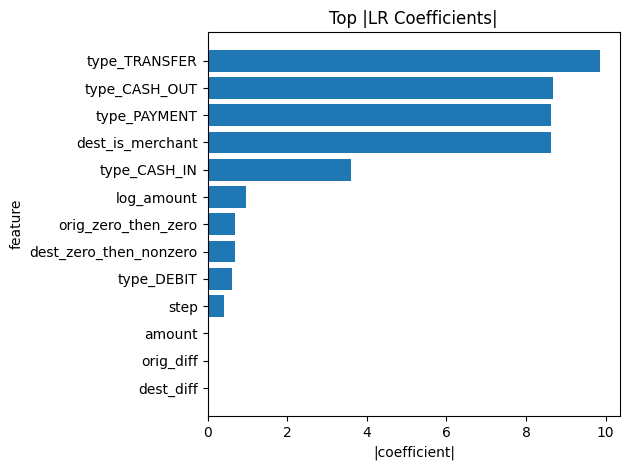

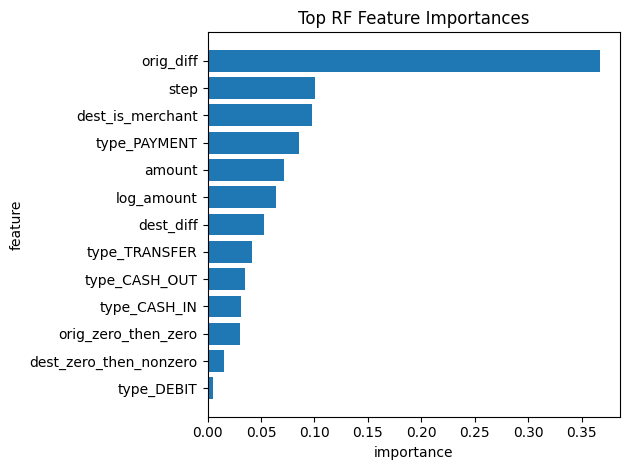

In [18]:

# ===== 5.2) Plot top features (two separate charts) =====
plt.figure()
plt.barh(coef_top["feature"][::-1], coef_top["abs_coef"][::-1])
plt.title("Top |LR Coefficients|")
plt.xlabel("|coefficient|")
plt.ylabel("feature")
plt.tight_layout()
plt.show()

plt.figure()
plt.barh(imp_top["feature"][::-1], imp_top["importance"][::-1])
plt.title("Top RF Feature Importances")
plt.xlabel("importance")
plt.ylabel("feature")
plt.tight_layout()
plt.show()


In [20]:

## Task 6 — Do These Factors Make Sense?

#Yes. In PaySim-style data, most fraud is concentrated in **TRANSFER** and **CASH_OUT**, often with patterns like:
#- **Account emptying**: `oldbalanceOrg - newbalanceOrig ≈ amount` (captured by `orig_diff ≈ 0`)
#- **Funds moving to non-merchants** (`dest_is_merchant == 0`), then cashed out
#- **Large amounts** (`log_amount` high)

#These behaviors match real-world fraud tactics where attackers move funds to mule accounts, then withdraw quickly to avoid detection.


In [ ]:

## Task 7 — Prevention Plan (Actionable Controls)

#From the model insights, adopt controls that reduce **speed** and **ease** of cashing out:
#1. **Real-time scoring**: score each transaction; hold those above threshold for secondary checks.
#2. **Cooling-off windows**: delay **CASH_OUT** immediately after large **TRANSFER**.
#3. **Velocity limits**: cap daily count/amount of risky types per device/account.
#4. **Dynamic limits**: stricter limits for new or low-verified users.
#5. **Counterparty risk**: downrank or block **first-time recipients** with bad history; score recipients too.
#6. **Step-up authentication**: extra verification for high-risk scores or unusual behavior.
#7. **Device & network signals**: fingerprint devices; flag mismatches and TOR/VPN-heavy traffic.
#8. **Human-in-the-loop**: route borderline cases to manual review; feed decisions back to model retraining.


In [ ]:

## Task 8 — How to Know It Works (Measurement Plan)

#Track these **weekly** (or daily) after rollout; compare to a pre-period or use an A/B holdout:

#.- **Fraud rate** (fraudulent txns / total) ↓
# **Loss prevented** (baseline expected loss − observed loss) ↑
#- **Recall on fraud** (caught fraud / total fraud) ↑
#- **False positive rate** and **customer friction** (challenge rates, appeal rates) stable/acceptable
#- **Time-to-detect** ↓ and **manual review queue** stable

#Create alerts on regressions; retrain or retune thresholds as behavior evolves.


In [21]:

# ===== Save best model based on PR-AUC =====
best_name = "LogReg" if pr_lr >= pr_rf else "RandForest"
best_pipe = pipe_lr if best_name == "LogReg" else pipe_rf
best_thr = float(thr_lr if best_name == "LogReg" else thr_rf)

print("Best by PR-AUC:", best_name, "with threshold:", best_thr)

dump(best_pipe, ART_DIR / f"fraud_model_{best_name}.joblib")
with open(ART_DIR / "threshold.json", "w") as f:
    json.dump({"model": best_name, "decision_threshold": best_thr}, f)

valid_scores = pd.DataFrame({
    "score": best_pipe.predict_proba(X_valid)[:,1],
    "isFraud": y_valid.values
}, index=y_valid.index)
valid_scores.to_csv(ART_DIR / "validation_scored.csv", index=False)

print("Saved to:", ART_DIR.resolve())


Best by PR-AUC: RandForest with threshold: 0.5
Saved to: C:\Users\91994\Desktop\ny\artifacts
